<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/HEIG-VD_Logo_96x29_RVB_ROUGE.png" alt="HEIG-VD Logo" width="250"/>

# TB - DevOps: Mise en place de cloud-native storage
## fio benchmark
**Note**: La version de fio utilisée pour chaque benchmark va être explicitement décrite tel que la license morale (section 4 [documentation](https://fio.readthedocs.io/en/latest/fio_doc.html#moral-license) fio) nous recommande.

Les tests se sont basés sur le benchmarking réalisé par Architecting-IT est accessible en [ligne](https://resources.storageos.com/downloadbenchmarkreport). Le benchmarking des différentes solutions ont réussi à démontré que StorageOs ressortait en tête parmi ses principaux concurrent en tant que solution de stockage block.

Ce que l'on va tenter de montrer est les différentes options proposées par Longhorn, essayer de comprendre son fonctionnement interne et voir si cela se manifeste dans notre benchmarking. 

Dans la méthodologie de test, on va montrer les différents déploiements utilisés (ce qui n'est pas fait dans le rapport par Architecting-IT) et proposer un déploiement via une image, ce qui aidera à la reproductibilité des tests effectués. Architecting-IT a effectué ses tests manuellement pour les raisons suivantes:
* To ensure that any lazy write process on file system creation didn’t affect the performance figures.
* To permit the validation of the container<->volume mapping and check the volume was the requisite size.
* To run iostat, top and iftop on each worker node. The output from these commands is not included but used to validate that there are no bottlenecks in CPU and network utilisation that could affect performance during test runs.

TODO demander à Marcel Graf si c'est grave? Est-ce que je devrais moi aussi run iostat+top+iftop pour guarantir qu'il n'y ait pas de CPU ou network bottleneck? 

On souhaite explorer les différents paramètres que Longhorn offre et voir leurs impacts dans les performances. Le hardware utilisé étant différent, on peut s'attendre à des résultats différents.

## Test en Local
Les résultats de cette section ont été généré à l'aide de fio version 3.16 à l'aide du script `run-all-jobs.sh`.

In [1]:
import json
# from: https://stackoverflow.com/a/3207973
from os import listdir
from os.path import isfile, join

fio_jobs_path = 'fio-jobs-output/local'
job_outputs_filename = [f for f in listdir(fio_jobs_path) if isfile(join(fio_jobs_path, f)) and 'output' in f]

In [2]:
job_outputs = []

# Load the results
for job_output in job_outputs_filename:
    f = open(f"{fio_jobs_path}/{job_output}")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0])

{'fio version': 'fio-3.16', 'timestamp': 1624716221, 'timestamp_ms': 1624716221209, 'time': 'Sat Jun 26 16:03:41 2021', 'global options': {'bs': '4K', 'iodepth': '256', 'direct': '1', 'ioengine': 'libaio', 'runtime': '120', 'numjobs': '4', 'size': '512M', 'name': 'raw-seqread', 'rw': 'read'}, 'jobs': [{'jobname': 'job1', 'groupid': 0, 'error': 0, 'eta': 0, 'elapsed': 121, 'job options': {'filename': '/dev/nvme0n1p7'}, 'read': {'io_bytes': 85691441152, 'io_kbytes': 83683048, 'bw_bytes': 714035839, 'bw': 697300, 'iops': 174325.156237, 'runtime': 120010, 'total_ios': 20920762, 'short_ios': 0, 'drop_ios': 0, 'slat_ns': {'min': 712, 'max': 318915, 'mean': 1345.356346, 'stddev': 891.144287}, 'clat_ns': {'min': 93938, 'max': 19756113, 'mean': 5872300.887986, 'stddev': 2146245.617705, 'percentile': {'1.000000': 1482752, '5.000000': 4014080, '10.000000': 4145152, '20.000000': 4227072, '30.000000': 4358144, '40.000000': 4489216, '50.000000': 5144576, '60.000000': 5406720, '70.000000': 7569408, '

## Test sur le cluster IICT
On souhaite déployer un container docker avec un PV dans le cluster IICT. Le container contient l'outil *fio* et un dossier *fio-jobs*.

Architecting-it a fait des [scripts](https://github.com/architectingit/k8sstorage/blob/main/perfraw.sh) pour réaliser ses tests. On va s'inspirer de leur script pour réaliser nos tests.

<u>**Connection au cluster IICT**</u>

Connectez-vous au VPN de l'école:
```bash
$ kubectl config get-contexts         # is ` iict ` listed ?
$ kubectl config use-context iict
```

<u>**Infrastructure testée**</u>

TODO mail à Rémi

### Benchmarking à la main
TODO refaire, edge case latency test output à pipe dans un fichier

Si vous désirer allez plus rapidement, sautez à la section suivante (on applique une configuration dans le cluster et récupère les résultats):

<u>**Déploiement**</u>

```bash
$ kubectl apply -f iict-fio-benchmark-manual.yaml
```

Observons quel classe de stockage sont disponibles :
```bash
$ kubectl get storageclass
NAME                 PROVISIONER                                     RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
longhorn (default)   driver.longhorn.io                              Delete          Immediate           true                   170d
nfs-client           cluster.local/nfs-subdir-external-provisioner   Delete          Immediate           true                   114d
```

Nous allons donc utiliser un PVC de storageclass `longhorn`.

<u>**Exécution des tests**</u>

Ensuite, on déploie un container simple:

```bash
$ kubectl apply --namespace=mercado -f iict-fio-benchmark-manual.yaml
```

On vérifie que le container a bien démarré:
```bash
$ kubectl get pods --namespace=mercado
```

On ouvre une session interactive et on install fio:
```bash
$ kubectl exec --namespace=mercado -it $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') -- /bin/sh
/ # apk add fio
/ # fio --version
$ exit # on sort de la session
```

On va copier un fio-job et un script permettant de run tous les tests:
```bash
# copy test script to pod
$ kubectl --namespace=mercado cp docker/iict/run-all-jobs.sh $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/

# copy all jobs to pod
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/random-read.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/random-readwrite.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/random-write.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/sequential-read.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/sequential-readwrite.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/sequential-write.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
```

Et on exécute les tests:
```bash
# ouvrir une session interactive
$ kubectl exec --namespace=mercado -it $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') -- /bin/sh
/ # sh run-all-jobs.sh
/ # exit
```

On récupère tous les outputs:
```shell
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/random-read.fio-output fio-jobs/iict/random-read.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/random-readwrite.fio-output fio-jobs/iict/random-readwrite.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/random-write.fio-output fio-jobs/iict/random-write.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/sequential-read.fio-output fio-jobs/iict/sequential-read.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/sequential-readwrite.fio-output fio-jobs/iict/sequential-readwrite.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/sequential-write.fio-output fio-jobs/iict/sequential-write.fio-output
```

Une fois que l'on a terminé, on nettoie:
```bash
kubectl delete -f iict-fio-benchmark-manual.yaml
```

### Image

Nous allons déployer une image contenant les scripts de tests et un script d'exécution des tests en quelques lignes. On déploie :

```bash
$ kubectl apply -f iict-fio-benchmark.yaml
```

On peut observer l'exécution du container en consultant les logs (ou en allant sur l'UI rancher qui se rafraîchit automatiquement):
```bash
$ kubectl logs --follow $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') --namespace=mercado
```

Une fois que les logs affiche `"All jobs done"`, alors on peut récupérer les output et nettoyer les ressources:

```bash
$ sh iict-fio-benchmark-get-output.sh
$ kubectl delete -f iict-fio-benchmark.yaml
```

Maintenant on va visualiser nos données:

In [3]:
# from: https://stackoverflow.com/a/3207973
from os import listdir
from os.path import isfile, join

fio_jobs_path = 'docker/iict/fio-jobs'
job_outputs_filename = [f for f in listdir(fio_jobs_path) if isfile(join(fio_jobs_path, f))]

In [4]:
import json

job_outputs = []

# Load the results
for job_output in job_outputs_filename:
    f = open(f"fio-jobs-output/iict/deployment-01-fs/{job_output}-output")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0])

{'fio version': 'fio-3.27', 'timestamp': 1625432411, 'timestamp_ms': 1625432411574, 'time': 'Sun Jul  4 21:00:11 2021', 'global options': {'name': 'read_bw', 'rw': 'randread', 'randrepeat': '0', 'verify': '0', 'ioengine': 'libaio', 'direct': '1', 'gtod_reduce': '1', 'bs': '128K', 'runtime': '30s', 'iodepth': '16', 'fdatasync': '0', 'size': '250G', 'ramp_time': '10s', 'filename': '/data/fiotest'}, 'jobs': [{'jobname': 'architecting-it-test3-read-bandwidth', 'groupid': 0, 'error': 0, 'eta': 0, 'elapsed': 42, 'read': {'io_bytes': 333447168, 'io_kbytes': 325632, 'bw_bytes': 10601779, 'bw': 10353, 'iops': 80.408241, 'runtime': 31452, 'total_ios': 2529, 'short_ios': 0, 'drop_ios': 0, 'slat_ns': {'min': 0, 'max': 0, 'mean': 0.0, 'stddev': 0.0, 'N': 0}, 'clat_ns': {'min': 0, 'max': 0, 'mean': 0.0, 'stddev': 0.0, 'N': 0}, 'lat_ns': {'min': 0, 'max': 0, 'mean': 0.0, 'stddev': 0.0, 'N': 0}, 'bw_min': 1539, 'bw_max': 26933, 'bw_agg': 100.0, 'bw_mean': 10448.612903, 'bw_dev': 4124.188013, 'bw_sampl

##### Déploiement d'une nouvelle image

Pour mettre à jour l'image que le cluster peut utiliser pour benchmark (avec de nouveaux scénarios de tests ou des modifications), on tag un commit de ce repository avec, par exemple :

```bash
$ git tag # what tag can we use?
...
v0.1.4
v0.1.5
v0.1.6
v0.1.7

$ git tag v0.1.8
$ git push origin tag v0.1.8
```

On patiente un moment que l'image soit mise en ligne puis on peut réaliser notre benchmark.

**Note**: La github Action ne build que les images en `v0.*.*` pour le moment.

# Traîtement de l'output
En s'inspirant des 9 jobs fait par Architecting-IT, on va extraire les résultats:

In [5]:
deployments_filename = [f.split('.')[0] for f in listdir('deployments/')]

def deployment_output_folder_path(is_iict: bool, idx: int):
    """
    :param is_iict: true if the deployment is related to IICT
    :param idx: the deployment
    :return: the deployment folder path
    """
    folder = "local"
    if is_iict:
        folder = "iict"
    dep = ""
    for d in deployments_filename:
        if str(idx) in d:
            dep = d

    return f"fio-jobs-output/{folder}/{dep}"

print(deployment_output_folder_path(is_iict=True, idx=1))

fio-jobs-output/iict/deployment-01-fs


In [6]:
def deployment_output(deployment_output_folder: str):
    """
    :param deployment_output_folder:
    :return: a filtered view of all jobs with relevant metrics
    """
    output = {}
    output['deployment name'] = deployment_output_folder
    for f in listdir(deployment_output_folder):
        o = json.load(open(f"{deployment_output_folder}/{f}"))
        if o['global options']['name'] == 'read_iops':
            # iops_mean is a stop criteria?
            output['read_iops'] = o['jobs'][0]['read']['iops']
        if o['global options']['name'] == 'write_iops':
            output['read_seq'] = o['jobs'][0]['write']['iops']
        if o['global options']['name'] == 'read_bw':
            output['read_bw'] = o['jobs'][0]['read']['bw_mean']
        if o['global options']['name'] == 'write_bw':
            output['read_seq'] = o['jobs'][0]['write']['bw_mean']
        # 0 bug in json output
        #if o['global options']['name'] == 'read_latency':
            #output['read_seq'] = o['jobs'][0]['read']['']
        # if o['global options']['name'] == 'write_latency':
        #     # TODO parse
        #     output['read_seq'] = o
        if o['global options']['name'] == 'seq_read':
            # TODO parse
            output['read_seq'] = o
        if o['global options']['name'] == 'seq_write':
            # TODO parse
            output['read_seq'] = o
        if o['global options']['name'] == 'rw_mix':
            # TODO parse
            output['read_seq'] = o
    return output

deployment_01 = deployment_output(deployment_output_folder_path(True, 1))
print(deployment_01)

{'deployment name': 'fio-jobs-output/iict/deployment-01-fs', 'read_seq': 3717.392157, 'read_iops': 1394.430397, 'read_bw': 10448.612903}


## Graphiques
On veut réaliser une comparaison avec des graphiques sur les différentes métriques testées.

In [7]:
deployments = [
    deployment_output(deployment_output_folder_path(True, 1)),
    deployment_output(deployment_output_folder_path(True, 3)),
    deployment_output(deployment_output_folder_path(True, 4)),
    deployment_output(deployment_output_folder_path(True, 5)),
    deployment_output(deployment_output_folder_path(True, 6)),
]

On va comparer l'IOPS pour *read*.

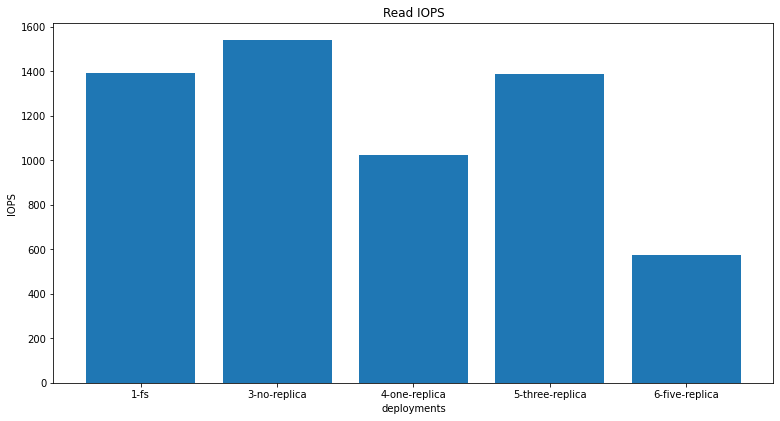

In [8]:
from matplotlib import pyplot as plt

read_iops = [d['read_iops'] for d in deployments]
deployments_name = [ d['deployment name'].split('0')[1] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Read IOPS')
ax.set_xlabel('deployments')
ax.set_ylabel('IOPS')
bar = plt.bar(deployments_name, read_iops)
plt.show()

# Configuration de Longhorn testée
* replicas
* [data locality](https://longhorn.io/docs/1.1.0/high-availability/data-locality/#data-locality-settings) (replica sur le même node que le workload)
* scheduling policy?
* volumeMode

[I/O operations and replicas](https://longhorn.io/docs/1.1.1/concepts/#231-how-read-and-write-operations-work-for-replicas)

Dans un volume Longhorn, lorsque les opérations I/O sont faites sur une replica, ces opérations se font d'abord sur le live data. Si le bloc cherché n'est pas sur le live data, alors, il va cherché le bloc dans la snapshot la plus récente jusqu'à ce qu'il trouve la bonne snapshot. Une fois trouvé, un index est conservé pour se souvenir de la snapshot la plus récente contenant le bloc recherché.

L'index est conservé en mémoire et a une taille de 1 byte par block de taille 4K.

[taille effective des volumes/replicas/snapshot](https://longhorn.io/docs/1.1.1/volumes-and-nodes/volume-size/#an-example-that-helps-understand-volume-size-and-volume-actual-size)

Au départ, les volumes ne prennent pas de places. Mais après qu'un document soit supprimé du FS dans le volume, cela n'est pas répliqué au niveau bloc: *"The truth of the data#1 deletion is that the data#1 is marked as removed in the filesystem level (For example, inode deletion in ext4). Since Longhorn operates on the block level and does not understand the filesystem, as a result, the disk blocks/space storing data#1 won’t be released after the deletion."*

Est-ce que ce serait intéressant de démontrer ça?

[Longhorn engine par volume](https://longhorn.io/docs/1.1.1/concepts/#11-the-longhorn-manager-and-the-longhorn-engine)

Super intéressant.

[replica par défaut](https://longhorn.io/docs/1.1.1/references/settings/#default-replica-count)

3 apparament??? Est-ce que je peux le vérifier moi-même?

[volumeMode block](https://longhorn.io/docs/0.8.0/examples/block-volume/)

what is this

[PV avec csi option, numberofreplicas](https://longhorn.io/docs/0.8.0/examples/csi-pv/)

[volumeMode: Filesystem](https://github.com/longhorn/longhorn/blob/8318d99136e0d5b39f01a37adf9cae5342034d7e/examples/csi/example_pv.yaml#L8)

[persistentVolumeReclaimPolicy: Delete](https://github.com/longhorn/longhorn/blob/8318d99136e0d5b39f01a37adf9cae5342034d7e/examples/csi/example_pv.yaml#L11)


Note: [google](https://cloud.google.com/compute/docs/disks/benchmarking-pd-performance) persistent disk benchmark

## Volume mode

[volume mode](https://longhorn.io/docs/0.8.0/install/customizing-default-settings/#via-longhorn-deployment-yaml-file)

* filesystem (défaut)
* block

Le type de volume [block](https://kubernetes.io/blog/2019/03/07/raw-block-volume-support-to-beta/#why-add-raw-block-volumes-to-kubernetes) est pour les applications spécialisées. Benchmarker un volume de ce type mène à une erreur ('Not a directory'). Est-ce possible de tester un raw block device avec fio ?

TODO chercher si raw block device test est possible

## Nombre de replicas

Par défaut, le nombre de replicas est de 3 tel que montré:

![idk](img/default-pvc-replicas.png)


On va tester les performances lorsqu'il y a 0, 1, 3 (par défaut) et 5 replicas (deployment-03-06).

<u>test 7 pbs</u>
* erreur 1 ligne (0 replica): il y a eu une erreur au test7 qui ne s'est pas reproduit. C'est étrange.
* erreurs multiples (1 replica): fio: io_u error on file /data/fiotest: Read-only file system: read offset=1048576000, buflen=1048576


In [9]:
t = deployment_output(deployment_output_folder_path(True, 3))

## Local et remote PV

On va faire un *deployment* avec le *container* et le PV dans un même *node*. Ensuite on va tester lorsque le container et le PV sont dans des nodes séparés.

On utilise l'attribut node-selector pour grouper/séparer le container et le pv. Les nodes disponibles sur le cluster sont:
```bash
$ kubectl get nodes
NAME           STATUS   ROLES                      AGE    VERSION
10.193.72.32   Ready    controlplane,etcd,worker   196d   v1.19.3
10.193.72.33   Ready    worker                     196d   v1.19.3
10.193.72.34   Ready    worker                     176d   v1.19.3
```

On a donc les différentes addresses IP comme noms. Pour assigner un Pod a un *node*, on attache d'abord un [label](https://kubernetes.io/docs/concepts/scheduling-eviction/assign-pod-node/#step-one-attach-label-to-the-node) au *node*. C'est une étape supplémentaire par rapport au autre configuration de test. Pour le *deployment* qui benchmark quand le PV est local, on fait:

```bash
$ kubectl label node 10.193.72.32 local-no-replica=node1
$ kubectl apply deployments/deployment-07-local-no-replica.yaml
$ kubectl label node 10.193.72.32 local-no-replica-
```

Pour le *deployment* qui benchmark quand le PV est remote, on fait:
```bash
$ kubectl label node 10.193.72.32 remote=node1
$ kubectl label node 10.193.72.33 remote=node2
$ kubectl apply deployments/deployment-08-remote.yaml
$ kubectl label node 10.193.72.32 remote-
$ kubectl label node 10.193.72.33 remote-
```

Voyons si des labels sont déjà attachés aux *nodes* du cluster IICT:
```bash
$ kubectl describe node 10.193.72.32
Name:               10.193.72.32
Roles:              controlplane,etcd,worker
Labels:             beta.kubernetes.io/arch=amd64
                    beta.kubernetes.io/os=linux
                    kubernetes.io/arch=amd64
                    kubernetes.io/hostname=10.193.72.32
                    kubernetes.io/os=linux
                    kubevirt.io/schedulable=false
                    node-role.kubernetes.io/controlplane=true
                    node-role.kubernetes.io/etcd=true
                    node-role.kubernetes.io/worker=true
...
```

On voit que le label `kubernetes.io/hostname=10.193.72.32` semble particulièrement intéressant. On vérifie que le label `kubernetes.io/hostname` permet de distinguer les trois `nodes` du cluster:
```bash
kubectl get node -l kubernetes.io/hostname=10.193.72.32
NAME           STATUS   ROLES                      AGE    VERSION
10.193.72.32   Ready    controlplane,etcd,worker   200d   v1.19.3
$ kubectl get node -l kubernetes.io/hostname=10.193.72.33
NAME           STATUS   ROLES    AGE    VERSION
10.193.72.33   Ready    worker   200d   v1.19.3
$ kubectl get node -l kubernetes.io/hostname=10.193.72.34
NAME           STATUS   ROLES    AGE    VERSION
10.193.72.34   Ready    worker   179d   v1.19.3
$ kubectl get node -l kubernetes.io/hostname=10.193.72.35
```

C'est le cas.
